In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Need to make sure that the changes in propagation constant of each core caused by the twisting don't prevent coupling

To model this we can take two approaches, the first of which is to find/derive an analytical expression.
Turning to: Ma X et al. 2011 Angular-momentum coupled optical waves in chirally-coupled-core fibers Opt. Expr. 19

They find: $ \beta_{hel} \approx \beta_{straight} \sqrt{1+\alpha^2 R^2}$ 
if $(\alpha R)^2$ is small we can approximate: $\beta_{hel} \approx \beta_{straight} + \frac{\beta_{straight}}{2}(\alpha R)^2$

Giving us $|\beta_{hel} - \beta_{straight}| = \Delta \beta \approx \frac{\beta_{straight}}{2}(\alpha R)^2$

Where $\alpha$ is the twist rate and R is helical radius (distance from centre of the fibre to the centre of the core)

In [5]:
R = 40e-6 # furthest core
R_next = 37.75e-6 # next nearest neighbour
twist = np.linspace(0,1000,1001)
beta_straight = 1.32113911e7 # From untwisted comsol system @ 700nm with 5um pitch, 1.5 um cores

def prop_changes(beta_0, alpha, hel_rad):
    return beta_0/2 * (alpha*hel_rad)**2

prop_change_outside = prop_changes(beta_straight, twist, R)
prop_change_neighbour = prop_changes(beta_straight, twist, R_next)


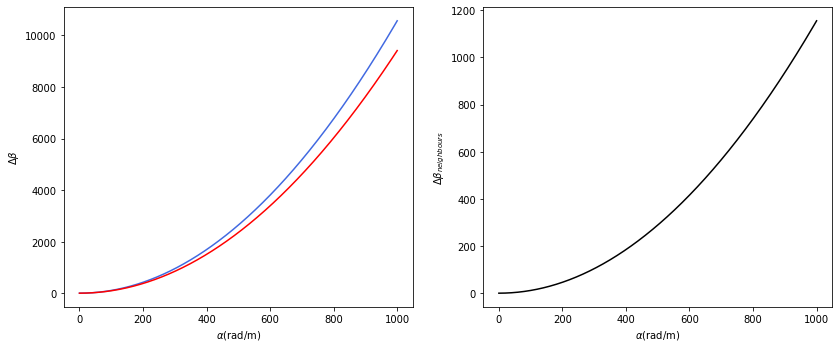

In [6]:
fig = plt.figure(figsize=(35/2.54, 14/2.54))
ax_analytic = fig.add_subplot(121)
ax_diff = fig.add_subplot(122)
ax_analytic.plot(twist,prop_change_outside, color='royalblue')
ax_analytic.plot(twist,prop_change_neighbour, color='red')
ax_analytic.set_xlabel(r'$\alpha$(rad/m)')
ax_analytic.set_ylabel(r'$\Delta \beta$')
ax_diff.plot(twist, prop_change_outside-prop_change_neighbour, color='black')
ax_diff.set_xlabel(r'$\alpha$(rad/m)')
ax_diff.set_ylabel(r'$\Delta \beta_{neighbours}$')
plt.show()

But what does this change in propagation constant mean for the coupling? 

In the untwisted case two nearest neighours have a coupling of $C = 112 $

We can describe power transmission as
 $P_2 = F^2 sin^2(\frac{Cz}{F}), P_1 = 1 - P_2, F = \frac{1}{\sqrt{1 + \frac{\beta_1 - \beta_2}{2C}}}$

In [46]:
z = np.linspace(0, 0.5, 10000)
coupling = 112
P2_untwisted = np.sin(coupling*z)**2
P1_untwisted = 1-P2_untwisted

fixed_twist = 100
prop_change_at_fixed = prop_changes(beta_straight,fixed_twist, R) - prop_changes(beta_straight,fixed_twist, R_next)
F = 1 / np.sqrt(1+(prop_change_at_fixed/(2*coupling)))
P2_twisted = F**2 *np.sin(coupling*z/F)**2 
P1_twisted = 1- P2_twisted

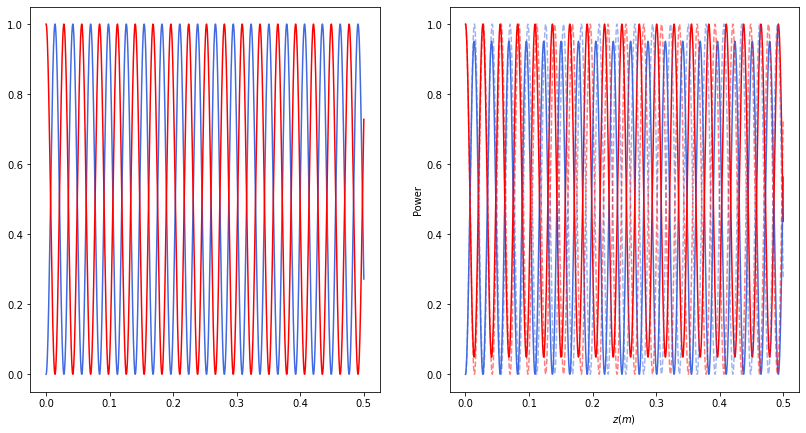

In [47]:
fig2 = plt.figure(figsize=(35/2.54, 18/2.54))
ax_untwisted = fig2.add_subplot(121)
ax_twisted = fig2.add_subplot(122)
ax_untwisted.plot(z,P2_untwisted, color='royalblue', label='Power 1')
ax_untwisted.plot(z,P1_untwisted, color='red', label='Power 2')
ax_analytic.set_xlabel(r'$ z (m)$')
ax_analytic.set_ylabel(r'Power')


ax_twisted.plot(z,P2_twisted, color='royalblue', label='Power 1')
ax_twisted.plot(z,P1_twisted, color='red', label='Power 2')
ax_twisted.plot(z,P2_untwisted, color='royalblue', label='Power 1', linestyle='--', alpha = 0.5)
ax_twisted.plot(z,P1_untwisted, color='red', label='Power 2', linestyle='--', alpha = 0.5)
ax_twisted.set_xlabel(r'$ z (m)$')
ax_twisted.set_ylabel(r'Power')
plt.show()

Taking a minute to think about what happens with a line of evenly spaced cores going out from the centre.
Ignoring any overall effects of twist, simply modelling it as detuned cores.
Something like $\Delta \beta_s \mathbf{a} = \begin{pmatrix}
0& C&0&0 \\
C &\Delta \beta & C &0 \\
0 & C & 2\Delta \beta& C \\
0 & 0 & C & 3 \Delta \beta
\end{pmatrix} \mathbf{a} 
$

In [7]:
def build_coupling_matrix_and_find_eigs(c, prop_change_fixed):
    coupling_matrix = np.array([[0,c, 0,0],[c, prop_change_fixed, c, 0],
                           [0, c, 2*prop_change_fixed, c],[0,0,c, 3*prop_change_fixed]])

    eigvals, eigvecs = np.linalg.eigh(coupling_matrix)
    return eigvals, eigvecs

In [8]:
def super_modes_at_dist(z,evals,evecs,input_vec):
    psi_list = np.zeros([len(evals),len(evals)],dtype=complex)

    for i,val in enumerate(evals):
        ind_vec = evecs[:,i]
        norm_ind_vec = ind_vec/np.sqrt(np.vdot(ind_vec,ind_vec))
        psi_list[:,i] = np.vdot(norm_ind_vec,input_vec)*norm_ind_vec*np.exp(1.0j*val*z)
    #print(psi_list)
    psi = np.sum(psi_list,axis=1)
    return psi

def core_basis(prop_wave, number_of_cores):
    core_matrix = np.eye(number_of_cores) 
    a_list = np.zeros(number_of_cores, dtype=complex)
    for i in range(number_of_cores):
        a_list[i] = np.vdot(core_matrix[:,i],prop_wave)
        
    return a_list

def propagator(z,evals,evecs,input_vec):
    supe = super_modes_at_dist(z,evals,evecs,input_vec)
    #print(supe)
    a_vals = core_basis(supe,len(evals))
    #print(a_vals)
    norm_vals = np.real(a_vals*np.conj(a_vals))

    #norm_vals = norm_vals/np.sqrt(np.vdot(norm_vals,norm_vals))
    return norm_vals

In [9]:
def propagation(z_list, evals, evecs, input_vec, threed=False):
    
    mode_intensities = np.zeros([len(evals),len(z_list)])
    print(np.shape(mode_intensities))
    for j,z in enumerate(z_list):
        mode_intensities[:,j] = propagator(z, evals, evecs, input_vec)
    
    return mode_intensities

In [10]:
input_intensity = np.array([1,0,0,0])
eigenvalues, eigenvectors = build_coupling_matrix_and_find_eigs(coupling, 0)
eigenvalues_detune, eigenvectors_detune = build_coupling_matrix_and_find_eigs(coupling, prop_change_at_fixed)
propagation_intensities = propagation(z, eigenvalues, eigenvectors, input_intensity)
propagation_intensities_twisted = propagation(z, eigenvalues_detune, eigenvectors_detune, input_intensity)

(4, 10000)
(4, 10000)


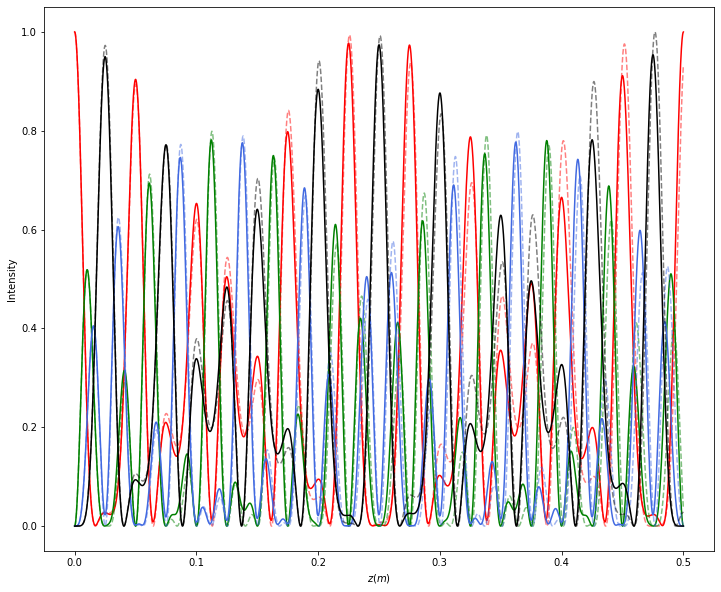

In [11]:
fig_prop = plt.figure(figsize=(12,10))
color_list = ['red', 'green', 'royalblue','black']
ax_prop = fig_prop.add_subplot(111)
for i in range(len(eigenvalues)):
    ax_prop.plot(z,propagation_intensities[i,:]/np.sum(propagation_intensities[:,0]),linestyle='--', alpha= 0.5,label='Power in core: {:d}'.format(i), color=color_list[i])
    ax_prop.plot(z,propagation_intensities_twisted[i,:]/np.sum(propagation_intensities_twisted[:,0]), label='Power in core: {:d}'.format(i), color=color_list[i])

ax_prop.set_xlabel(r'$ z (m)$')
ax_prop.set_ylabel('Intensity') 
plt.show()       

## Comparing theory with simulations 

In [2]:
comsol_data_edge = pd.read_csv('../COMSOL/Data/Honeycomb/twist effect on beta of edge core.csv', header=4)
comsol_data_centre = pd.read_csv('../COMSOL/Data/Honeycomb/twist effect on beta of central core.csv', header=4)
comsol_data_edge_pol_1 = comsol_data_edge[::2].reset_index(drop=True)
comsol_data_edge_pol_2 = comsol_data_edge[1::2].reset_index(drop=True)
comsol_data_centre_pol_1 = comsol_data_centre[::2].reset_index(drop=True)
comsol_data_centre_pol_2 = comsol_data_centre[1::2].reset_index(drop=True)

comsol_data_centre_pol_1['Prop Change'] = np.abs(comsol_data_centre_pol_1['Propagation constant (rad/m)'] - comsol_data_centre_pol_1['Propagation constant (rad/m)'][0])
comsol_data_centre_pol_2['Prop Change'] = np.abs(comsol_data_centre_pol_2['Propagation constant (rad/m)'] - comsol_data_centre_pol_2['Propagation constant (rad/m)'][0])
comsol_data_edge_pol_1['Prop Change'] = np.abs(comsol_data_edge_pol_1['Propagation constant (rad/m)'] - comsol_data_edge_pol_1['Propagation constant (rad/m)'][0])
comsol_data_edge_pol_2['Prop Change'] = np.abs(comsol_data_edge_pol_2['Propagation constant (rad/m)'] - comsol_data_edge_pol_2['Propagation constant (rad/m)'][0])

twists = np.unique(comsol_data_centre_pol_2["% twist (rad/m)"])

In [3]:
display(comsol_data_centre_pol_1)
print(twists)

,% twist (rad/m),lambda,Propagation constant (rad/m),Prop Change
0,0,1.471861,1.321139e+07,0.000000
1,20,1.471860,1.321139e+07,4.719302
2,40,1.471859,1.321138e+07,14.832181
3,60,1.471858,1.321137e+07,24.285808
4,80,1.471857,1.321136e+07,29.298725
5,100,1.471858,1.321136e+07,27.877537
6,120,1.471859,1.321137e+07,19.562704
7,140,1.471860,1.321138e+07,6.672748
8,160,1.471861,1.321139e+07,0.130330
9,180,1.471859,1.321137e+07,17.531021


[  0  20  40  60  80 100 120 140 160 180 200]


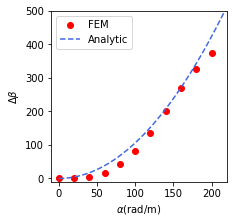

In [10]:
fig_sim = plt.figure(figsize=(8/2.54, 8/2.54))
ax_sim = fig_sim.add_subplot(111)
# ax_sim_diff = fig_sim.add_subplot(122)
#ax_sim.plot(twists, comsol_data_centre_pol_1['Prop Change'].to_numpy(), color='royalblue')
ax_sim.scatter(twists, comsol_data_edge_pol_1['Prop Change'].to_numpy(), color='red', label='FEM')
ax_sim.plot(twist,prop_change_outside, color='royalblue', linestyle='--', label='Analytic')
ax_sim.set_xlabel(r'$\alpha$(rad/m)')
ax_sim.set_ylabel(r'$\Delta \beta$')
# ax_sim_diff.plot(twists, comsol_data_centre_pol_1['Prop Change'].to_numpy() - comsol_data_edge_pol_1['Prop Change'].to_numpy(), color='black')
# ax_sim_diff.set_xlabel(r'$\alpha$(rad/m)')
# ax_sim_diff.set_ylabel(r'$\Delta \beta_{edge_to_centre}$')
ax_sim.set_xlim([-10,220])
ax_sim.set_ylim([-10,500])
plt.legend()
plt.show()
fig_sim.savefig('../Twisted Fibre/prop_change_due_to_twist_40um.svg', dpi=300)